In [1]:
import numpy              as np
import pandas             as pd
import scipy              
import matplotlib.pyplot  as plt

from matplotlib.ticker import FormatStrFormatter # to set the format of the plot's axis

import os
import math
import tables as tb

# Global parameters

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

In [3]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

In [4]:
event_id = 56

v_d = 967.99*1e-6 # [mm/ns] = 967.99 [um/us] Drift velocity
Xe_ion = 11.14*1e-6 # [MeV] Xe ionization potential
EL_gain = 75 # optical gain 

e_lt = 16e5 # electron lifetime
recombi = 0.026 # recombination factor

z_max = 1.5e3 # [mm] Detector length/2
z_min = -z_max # symmetric detector

# Data

## Units are fundamental units used in Geant4, ie:

### Length [L]: mm (milimeter)
### Time [T]: ns (nanosecond)
### Energy [E]: MeV (megaelectronvolt)


In [5]:
path = '/home/investigator/mariandbt/nexus/'

filename = os.path.join(path, "Xe_tank_bb0nu.next.h5")

In [6]:
# inside a .h5 file there are several objects, let's see which data-set (dst) we want
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Xe_tank_bb0nu.next.h5 (File) ''
Last modif.: '2023-03-27T15:22:22+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(36,)) ''
/MC/hits (Table(1499311,)) ''
/MC/particles (Table(317632,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''



In [7]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
dst = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [8]:
dst['time'].min()

3.2897918345042854e-07

# Electron distribution on time

### Number of events

In [9]:
# n_events = dst['event_id'].max() + 1
n_events = len(dst['event_id'].unique())

### Total time = initial time + drift time

In [10]:
drift_time = (z_max - dst['z'])/(v_d) # [ns]
dst['drift_time'] = drift_time
dst['tot_time'] = dst['time'] + drift_time
# dst = dst.sort_values(by = ['tot_time'])

### Number of electrons = (energy deposition) * (EL gain) * (1 - recombination factor) * (lifetime factor)/ (ionization energy Xe)

In [11]:
n_e = np.floor(dst['energy']*EL_gain*(1 - recombi)*np.exp(-dst['drift_time']/e_lt)/Xe_ion)
dst['n_e'] = n_e

In [12]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

# ax.plot(dst['tot_time'][:1000], dst['n_e'][:1000], '-', label='N_e vs time')
# ax.set_ylabel('Number of electrons');
# ax.set_xlabel('Time [ns]');

In [13]:
dst['event_id'].max(), len(dst['event_id'].unique()), len(dst['n_e']), dst['n_e'].sum()

(9999, 10000, 1499311, 67442299804.0)

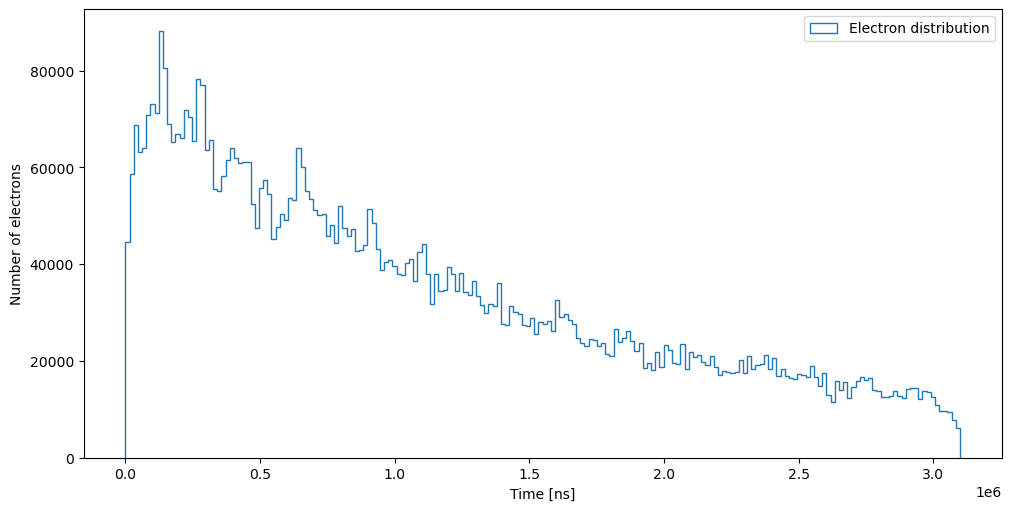

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

#_________plot_settings_________________________________________________

events, bins, bars = ax.hist(dst['tot_time'], 200, weights=dst['n_e']/n_events, density=False, 
                             label='Electron distribution', histtype='step')
    
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

# gaussian fit
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 

# a, mu, sigma = popt
# best_fit_line = gauss(x_ax, a, mu, sigma)

# ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

# ax.text(0.05, .9, 'patata', transform=ax.transAxes, fontsize=15, verticalalignment='top', 
#         fontfamily='serif', bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.set_ylabel('Number of electrons');
ax.set_xlabel('Time [ns]');
ax.legend(fontsize=10, loc='best')


In [15]:
dst['n_e'].sum()/n_events-events.sum()

-9.313225746154785e-10

In [16]:
events.sum(), events.max()

(6744229.980400001, 88259.8972)

In [17]:
bins[2]-bins[1]

15496.04381073826